In [ ]:
import gensim
gensim.__version__

'4.3.2'

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 35.3 MB/s eta 0:00:00


# 1. 영어 Word2Vec 만들기

In [ ]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

# 정규 표현식 라이브러리 불러오기
import re

# URL을 통해 데이터를 요청할 때 사용하는 라이브러리
import urllib.request

# zip 파일을 처리하기 위한 라이브러리
import zipfile

# XML 및 HTML 문서를 파싱할 때 사용하는 lxml 라이브러리의 etree 모듈
from lxml import etree

# 자연어 처리를 위한 nltk 라이브러리에서 단어 및 문장 토크나이즈 함수 불러오기
from nltk.tokenize import word_tokenize, sent_tokenize


In [ ]:
import nltk
# 'punkt' 패키지는 문장과 단어를 토큰화하는 데 사용됨
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 훈련데이터 다운로드 (ted talk script)
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7e31f1ccc610>)

In [ ]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')


In [ ]:
targetXML

<_io.TextIOWrapper name='ted_en-20160408.xml' mode='r' encoding='UTF8'>

In [ ]:
target_text = etree.parse(targetXML)

# xml 파일에서 추출한 text로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 '문장' 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 '단어' 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
print('총 샘플(문장)의 개수 : {}'.format(len(result)))

총 샘플(문장)의 개수 : 273424


In [ ]:
# 샘플(문장) 3개만 출력해서 토큰화된 단어 확인
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

- `vector_size`
  - 임베딩 된 벡터의 차원
  - 단어를 숫자 벡터로 표현할 때 벡터가 몇 개의 숫자로 이루어져 있을지 결정.
  - 예: vector_size=100 → 각 단어가 100개의 숫자로 구성된 벡터로 표현.
  - 벡터의 차원이 클수록 더 많은 정보 포함 가능, 계산 비용 증가.

- `window`
  - 컨텍스트 윈도우 크기
  - 특정 단어의 주변 단어를 몇 개까지 고려할지 결정.
  - 예: window=5 → 특정 단어 앞뒤로 5개씩 총 10개의 단어를 문맥으로 고려.
  - 큰 값 설정 시 더 넓은 문맥 고려, 너무 크면 관련성 떨어질 수 있음.

- `min_count`
  - 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
  - 등장 빈도가 일정 수준 이하인 단어는 학습에서 제외.
  - 예: min_count=2 → 텍스트 전체에서 두 번 이하로 등장한 단어는 학습하지 않음.
  - 드물게 등장하는 단어가 모델에 큰 영향을 주지 않도록 설정.
- `workers`
  - 학습을 위한 프로세스 수
  - 모델 학습 시 동시에 사용할 CPU 코어 수 결정
  - 예: workers=4 → 4개의 CPU 코어를 사용하여 병렬로 학습 수행. 학습 속도 향상
- `sg`
  - 0은 CBOW, 1은 Skip-gram.
  - 학습 알고리즘 선택. sg=0 → CBOW(Continuous Bag of Words) 사용, 주변 단어로 중심 단어 예측. CBOW는 빠르고, 데이터가 많은 경우 효과적.
  - sg=1 → Skip-gram 사용, 중심 단어로 주변 단어 예측. Skip-gram은 적은 데이터에서도 좋은 성능 발휘 가능.

CBOW는 target word 근처의 문맥을 파악하여 target word를 예측하는 방법이고, Skip-gram은 target word를 보고 문맥을 예측하는 방법입니다. `window`란 인자는 근처 문맥의 단어를 몇개로 할지 그 크기를 설정하는 인자입니다.

![neural language model vs word2vec](https://user-images.githubusercontent.com/115082062/213910013-2c91f210-090d-47f7-b842-33f64a3b2c50.png)


In [ ]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [ ]:
# 단어 벡터의 유사성을 계산
similar_words = model.wv.most_similar(
    positive=['woman'],  # 'woman' 벡터와 유사한 단어들을 찾음
    negative=['man']     # 'man' 벡터와는 유사하지 않은 단어들을 찾음
)

print(similar_words)


[('sex', 0.35056132078170776), ('cancer', 0.34066322445869446), ('married', 0.3404623866081238), ('failed', 0.33121252059936523), ('child', 0.322372704744339), ('pregnant', 0.31088441610336304), ('treated', 0.3105982542037964), ('secondary', 0.3031962513923645), ('usually', 0.2926960587501526), ('chosen', 0.28513920307159424)]


In [ ]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
# 로드한 모델을 사용하여 'ball'과 유사한 단어들을 찾음
model_result = loaded_model.most_similar("ball")

print(model_result)


[('plane', 0.7779138088226318), ('balloon', 0.7705575227737427), ('rock', 0.7618331909179688), ('glass', 0.7517911791801453), ('button', 0.7506078481674194), ('wheel', 0.7262601852416992), ('rope', 0.7214344143867493), ('flower', 0.7084842324256897), ('swing', 0.7046749591827393), ('bag', 0.698011040687561)]


# 2. 한국어 Word2Vec 만들기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import tqdm

In [ ]:
# 네이버 영화 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7e31bc392dd0>)

In [ ]:
train_data = pd.read_table('ratings.txt')

In [ ]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
train_data.info() # 결측값이 존재하는 행 8개 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [ ]:
train_data = train_data.dropna(how = 'any') # 결측 값 존재하는 행 제거

In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 불용어 리스트 정의
with open('/content/drive/MyDrive/stopword.txt',  encoding='utf-8') as f:
    list_file = f.readlines()
    stopwords = list_file[0].split(",")

In [ ]:
# using okt
okt = Okt()

tokenized_data = []
for sentence in tqdm.tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [21:09<00:00, 157.52it/s]


In [ ]:
# 리뷰 3개의 토큰화 결과만 출력
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '으로', ',', '외국', '디자이너', '와', '그', '들', '이', '일군', '전통', '을', '통해', '발전', '하다', '문화', '산업', '이', '부럽다', '.', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '에', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '이', '있다', '저', '와', '같다', '사람', '들', '이', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '에', '감사하다', '.'], ['폴리스스토리', '시리즈', '는', '1', '부터', '뉴', '까지', '버리다', '하나', '도', '없다', '..', '최고', '.']]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 14.386465458618344


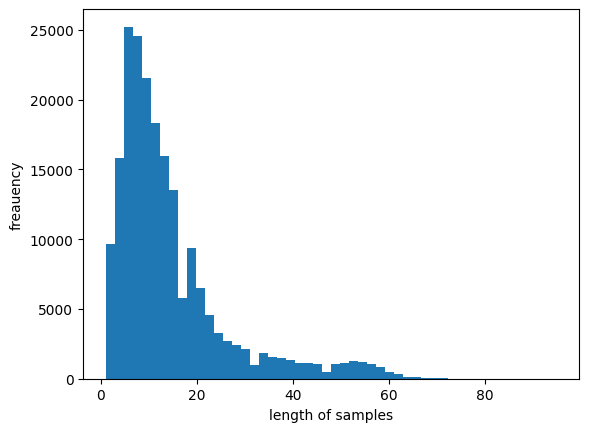

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('freauency')
plt.show()

In [ ]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
model.wv.vectors.shape # 총 17633개의 단어가 100차원으로 구성되어있음.

(17633, 100)

In [ ]:
print(model.wv.most_similar("이동진"))

[('****', 0.7636345624923706), ('김혜리', 0.7485103607177734), ('황진', 0.7366546988487244), ('이응', 0.7191000580787659), ('영화평론가', 0.7165066599845886), ('민영', 0.7157342433929443), ('무뇌충', 0.7043491005897522), ('한겨레', 0.7039509415626526), ('악플달다', 0.7013012766838074), ('이세영', 0.6999034285545349)]


In [ ]:
model.wv.most_similar(positive=['타짜'])

[('REC', 0.823891282081604),
 ('번개', 0.8153518438339233),
 ('토이스토리', 0.8113719820976257),
 ('용형', 0.808111310005188),
 ('아나콘다', 0.8000749349594116),
 ('맞짱', 0.7956007122993469),
 ('논스톱', 0.7953426837921143),
 ('이언', 0.7917523980140686),
 ('마더', 0.7912107110023499),
 ('에이리언', 0.7867870330810547)]

In [ ]:
model.wv.most_similar(positive=['송강호'], negative=['주연'])

[('우즈', 0.5109618902206421),
 ('유쾌', 0.49382948875427246),
 ('마무', 0.4907868206501007),
 ('오우', 0.48675230145454407),
 ('로치', 0.4861409664154053),
 ('아담샌들러', 0.48492634296417236),
 ('시로', 0.4812896251678467),
 ('김영호', 0.48112332820892334),
 ('핫', 0.47724243998527527),
 ('구조대', 0.47660887241363525)]

In [ ]:
model.wv.similarity('송강호', '하정우')

0.76849353